In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 3
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c4_img20250512-12_06_55CEST.jpg"
overlay_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c4_img20250512-11_57_42CEST.jpg"


delta_pitch_deg=15.0
delta_yaw_deg=-3.5 
delta_roll_deg=3.5 
delta_r=0.001

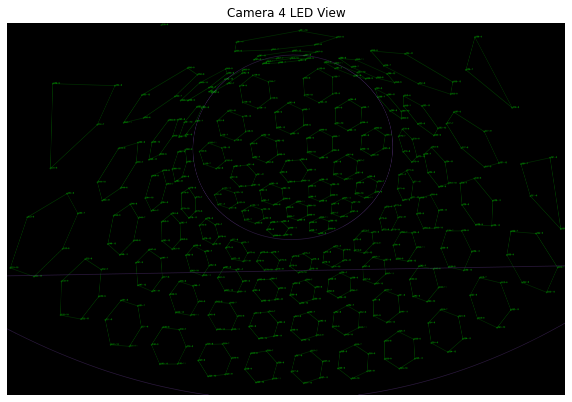

Saved image to camera4_f3253_p15_y-3_r3_dr0.png


In [3]:
excluded_pmts = {21, 26, 27, 30, 32, 34, 35, 36, 45, 51, 57, 63, 66, 67, 68, 82, 83, 84, 74, 77, 79, 85, 91, 96, 99, 102}

prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts={})

In [4]:

blobs = prim.run_blob_detector( cur_cam_index, image_filename_current )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 50)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 219
number of blobs: 219


In [5]:
prim.draw_image_with_blobs_save( cur_cam_index, image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c4_with_blob_annotation.jpg


In [6]:
# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

control_points = {
    '048-9': (1726, 3308),
    '023-11': (8591, 4939),
    '093-8': (4805, 1370)
}

matches, fitpars = prim.match_blobs(
                            blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, 
                            excluded_pmts=excluded_pmts,
                            bounds = [
                                        (10, 20),   # delta_pitch_deg
                                        (-5, 5),   # delta_yaw_deg
                                        (-5, 5),   # delta_roll_deg
                                        (-0.01, 0.01), # delta_r in meters
                                        (-0.082, 0.086), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
                                        (-0.007, 0.009), # k2
                                        (-0.0005, 0.0008), # k3
                                        (-0.0001, 0.0002)   ],
                            control_points=control_points,  
                            use_lm=True )

In [7]:
fitpars

{'delta_pitch_deg': 15.755647896673667,
 'delta_yaw_deg': -3.5720226321107895,
 'delta_roll_deg': 3.2549315073754435,
 'delta_r': 0.08581700251551952,
 'D_fit': array([ 0.10277033, -0.13275317,  0.1235036 , -0.03490766]),
 'chi2': 8040201.58912387,
 'success': True}

In [8]:
len(matches)

210

In [9]:
matches

[('022-6', 9052.578, 3627.7175),
 ('022-7', 8632.865, 3599.5645),
 ('022-10', 9189.209, 4632.96),
 ('023-7', 8079.203, 4403.933),
 ('023-8', 7899.5063, 4703.912),
 ('023-9', 8013.3667, 5096.823),
 ('023-11', 8580.283, 4935.0483),
 ('024-6', 7704.5645, 5061.31),
 ('024-7', 7409.5205, 4954.888),
 ('024-8', 7193.356, 5179.5215),
 ('024-9', 7235.642, 5515.531),
 ('024-10', 7514.362, 5660.0205),
 ('024-11', 7768.245, 5431.716),
 ('025-6', 6944.788, 5455.014),
 ('025-7', 6686.32, 5326.9253),
 ('025-8', 6447.714, 5494.0654),
 ('025-9', 6442.446, 5794.12),
 ('025-10', 6688.664, 5945.509),
 ('025-11', 6953.4253, 5775.5864),
 ('028-8', 4140.089, 5726.637),
 ('028-9', 4044.0889, 5977.41),
 ('028-10', 4227.7905, 6188.3564),
 ('029-8', 3366.375, 5567.713),
 ('029-9', 3236.4333, 5822.3706),
 ('029-10', 3400.6858, 6076.415),
 ('031-7', 2174.285, 4877.5967),
 ('031-8', 1875.9487, 4784.738),
 ('031-9', 1616.9951, 5110.3735),
 ('031-10', 1718.5978, 5526.945),
 ('031-11', 2046.4073, 5565.417),
 ('033-7',

In [10]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts,
    control_points=control_points,    
    overlay_image_name=overlay_filename_current,
    alpha=0.2
)


{'delta_pitch_deg': 15.755647896673667, 'delta_yaw_deg': -3.5720226321107895, 'delta_roll_deg': 3.2549315073754435, 'delta_r': 0.08581700251551952, 'D_fit': array([ 0.10277033, -0.13275317,  0.1235036 , -0.03490766]), 'chi2': 8040201.58912387, 'success': True}
Overlay image saved to: c4_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {66, 67, 68, 74, 77, 79, 82, 83, 84, 21, 85, 26, 27, 91, 30, 32, 96, 34, 35, 36, 99, 102, 45, 51, 57, 63}
geo_file= wcte_geometry_file.json
Sample matches labels: [('022-6', 9052.578, 3627.7175), ('022-7', 8632.865, 3599.5645), ('022-10', 9189.209, 4632.96), ('023-7', 8079.203, 4403.933), ('023-8', 7899.5063, 4703.912), ('023-9', 8013.3667, 5096.823), ('023-11', 8580.283, 4935.0483), ('024-6', 7704.5645, 5061.31), ('024-7', 7409.5205, 4954.888), ('024-8', 7193.356, 5179.5215)]
Sample label_to_sim keys: ['022-6', '022-7', '022-8', '022-9', '022-10', '023-6', '023-7', '023-8', '023-9', '023-10']
Saved results to c4_img20250512-12_06_55CEST.json
